In [33]:
import os
project_root = os.path.abspath("..")      
if project_root not in sys.path:
    sys.path.append(project_root)


In [34]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-darkgrid")


In [35]:
from generative_models.NaiveBayes import GaussianNaiveBayes, MultinomialNaiveBayes
from discriminative_models.GLM import BernoulliLogitGLM, SoftmaxGLM
from generative_models.GDA import GDA, GDA_Multiclass

np.random.seed(42)

In [36]:
n = 500
d = 2

X0 = np.random.multivariate_normal(
    mean=[-1.0, 0.0],
    cov=[[1.0, 0.3], [0.3, 1.0]],
    size=n // 2
)
X1 = np.random.multivariate_normal(
    mean=[1.0, 0.5],
    cov=[[1.0, -0.2], [-0.2, 1.2]],
    size=n // 2
)

X = np.vstack([X0, X1])
y = np.array([0] * (n // 2) + [1] * (n // 2))


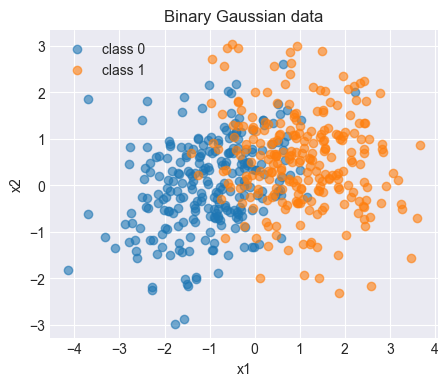

In [37]:
plt.figure(figsize=(5, 4))
plt.scatter(X0[:, 0], X0[:, 1], c="tab:blue", label="class 0", alpha=0.6)
plt.scatter(X1[:, 0], X1[:, 1], c="tab:orange", label="class 1", alpha=0.6)
plt.legend()
plt.title("Binary Gaussian data")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()


In [38]:
# Gaussian Naive Bayes
gnb = GaussianNaiveBayes().fit(X, y)
y_gnb = gnb.predict(X)
acc_gnb = (y_gnb == y).mean()

# Logistic GLM (discriminative)
log_glm = BernoulliLogitGLM(lr=0.1, n_iters=1000)
log_glm.fit(X, y)
y_log = log_glm.predict(X)
acc_log = (y_log == y).mean()

# GDA (full covariance generative)
gda = GDA().fit(X, y)
y_gda = gda.predict(X)
acc_gda = (y_gda == y).mean()

acc_gnb, acc_log, acc_gda


(0.852, 0.844, 0.846)

In [39]:
def plot_decision_boundary_2d(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200),
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(5, 4))
    plt.contourf(xx, yy, Z, alpha=0.2, levels=[-0.5, 0.5, 1.5], colors=["#1f77b4", "#ff7f0e"])
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c="tab:blue", label="class 0", edgecolor="k", s=30)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c="tab:orange", label="class 1", edgecolor="k", s=30)
    plt.title(title)
    plt.legend()
    plt.show()


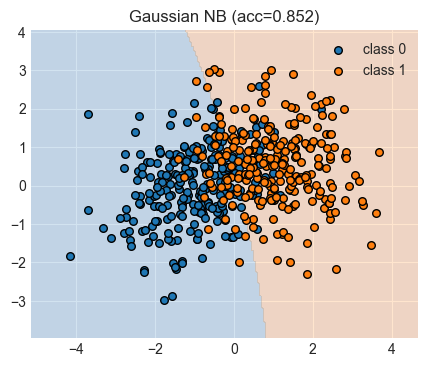

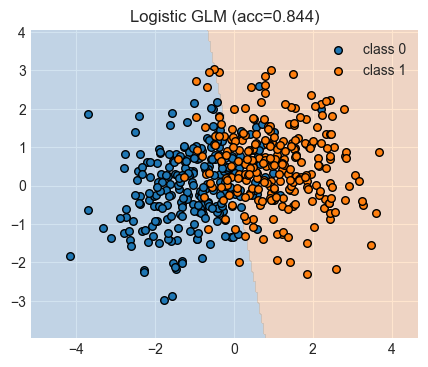

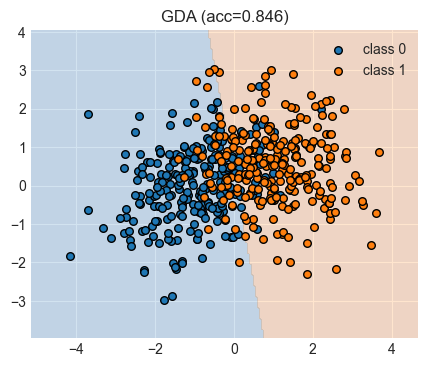

In [40]:
plot_decision_boundary_2d(gnb, X, y, f"Gaussian NB (acc={acc_gnb:.3f})")
plot_decision_boundary_2d(log_glm, X, y, f"Logistic GLM (acc={acc_log:.3f})")
plot_decision_boundary_2d(gda, X, y, f"GDA (acc={acc_gda:.3f})")


In [41]:
n = 600
d = 5  # vocab size
K = 3
doc_len = 20

phi_true = np.array([
    [0.6, 0.1, 0.1, 0.1, 0.1],   # class 0
    [0.1, 0.6, 0.1, 0.1, 0.1],   # class 1
    [0.1, 0.1, 0.1, 0.6, 0.1],   # class 2
])

X_counts = np.zeros((n, d), dtype=int)
y_counts = np.zeros(n, dtype=int)

for i in range(n):
    c = np.random.randint(0, K)
    y_counts[i] = c
    X_counts[i] = np.random.multinomial(doc_len, phi_true[c])


In [42]:
# Multinomial NB
mnb = MultinomialNaiveBayes(alpha=1.0).fit(X_counts, y_counts)
y_mnb = mnb.predict(X_counts)
acc_mnb = (y_mnb == y_counts).mean()

# Softmax GLM (treat counts as features)
softmax_glm = SoftmaxGLM(lr=0.1, n_iters=500, method="batch")
softmax_glm.fit(X_counts, y_counts)
y_soft = softmax_glm.predict(X_counts)
acc_soft = (y_soft == y_counts).mean()

acc_mnb, acc_soft


(0.9983333333333333, 0.9966666666666667)

In [43]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [44]:
import sklearn
from sklearn.metrics import confusion_matrix

def plot_confusion(cm, class_names, title="Confusion matrix"):
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, cmap="Blues")

    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max() / 2 else "black")

    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()


def per_class_accuracy(y_true, y_pred, class_names=None):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    classes = np.unique(y_true) if class_names is None else np.arange(len(class_names))

    accs = {}
    for c in classes:
        mask = (y_true == c)
        acc = (y_pred[mask] == y_true[mask]).mean()
        name = c if class_names is None else class_names[c]
        accs[name] = acc
    return accs


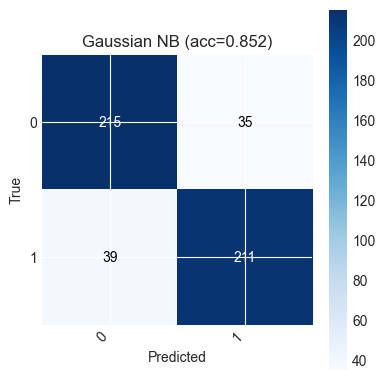

Gaussian NB per-class acc: {'0': 0.86, '1': 0.844}


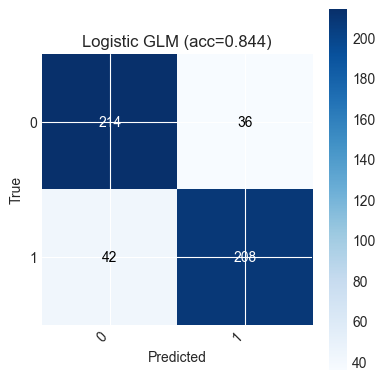

Logistic GLM per-class acc: {'0': 0.856, '1': 0.832}


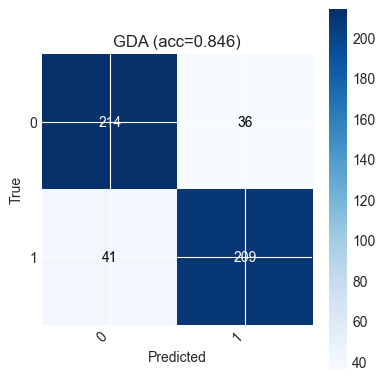

GDA per-class acc: {'0': 0.856, '1': 0.836}


In [45]:
class_names_bin = ["0", "1"]

# Gaussian NB
cm_gnb = confusion_matrix(y, y_gnb)
plot_confusion(cm_gnb, class_names_bin, title=f"Gaussian NB (acc={acc_gnb:.3f})")
print("Gaussian NB per-class acc:", per_class_accuracy(y, y_gnb, class_names_bin))

# Logistic GLM
cm_log = confusion_matrix(y, y_log)
plot_confusion(cm_log, class_names_bin, title=f"Logistic GLM (acc={acc_log:.3f})")
print("Logistic GLM per-class acc:", per_class_accuracy(y, y_log, class_names_bin))

# GDA
cm_gda = confusion_matrix(y, y_gda)
plot_confusion(cm_gda, class_names_bin, title=f"GDA (acc={acc_gda:.3f})")
print("GDA per-class acc:", per_class_accuracy(y, y_gda, class_names_bin))



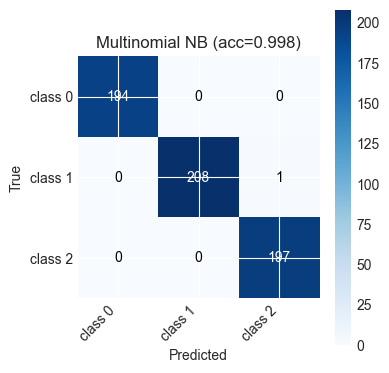

Multinomial NB per-class acc: {'class 0': 1.0, 'class 1': 0.9952153110047847, 'class 2': 1.0}


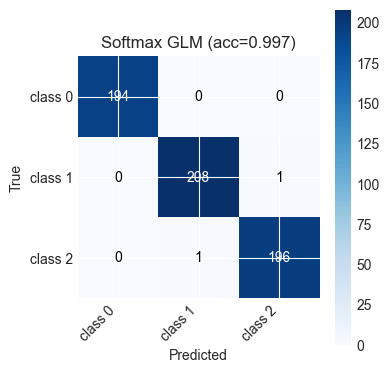

Softmax GLM per-class acc: {'class 0': 1.0, 'class 1': 0.9952153110047847, 'class 2': 0.9949238578680203}


In [46]:
class_names_multi = [f"class {k}" for k in range(K)]

cm_mnb = confusion_matrix(y_counts, y_mnb)
plot_confusion(cm_mnb, class_names_multi,
               title=f"Multinomial NB (acc={acc_mnb:.3f})")
print("Multinomial NB per-class acc:",
      per_class_accuracy(y_counts, y_mnb, class_names_multi))

cm_soft = confusion_matrix(y_counts, y_soft)
plot_confusion(cm_soft, class_names_multi,
               title=f"Softmax GLM (acc={acc_soft:.3f})")
print("Softmax GLM per-class acc:",
      per_class_accuracy(y_counts, y_soft, class_names_multi))
      
